In [1]:
import sys
import os
sys.path.append('./flash3d')
sys.path.append('./flash3d/flash3d')
from flash3d.generator_test import Flash3DReconstructor
import torch
import types
from PIL import Image
from torchvision.utils import save_image
from torchvision.transforms.functional import to_pil_image
from flash3d.flash3d.util.export_param import postprocess, save_ply
import numpy as np
from torchvision import transforms
from vlm_diffusion_pipeline import main as generate_diffusion_img
from matplotlib import pyplot as plt
from diffusers.utils import load_image, make_image_grid

c:\Users\UTastePC\miniconda3\envs\8536\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Set the path to the input image and the output directory, the input image is the very first image of the whole pipeline
intial_img_path = './flash3d/frame000652.jpg'
output_path = './flash3d-output'
current_directory = './flash3d-cache'

In [3]:
# Define the model, from Jiaqi's code at /flash3d/generator_test.py
flash3dreconstructor = Flash3DReconstructor()

A matching Triton is not available, some optimizations will not be enabled
Traceback (most recent call last):
  File "c:\Users\UTastePC\miniconda3\envs\8536\lib\site-packages\xformers\__init__.py", line 57, in _is_triton_available
    import triton  # noqa
ModuleNotFoundError: No module named 'triton'
d:\Local\Courses\COMP8536\3dgs-utils\ANU-COMP8536-2024s2\./flash3d/flash3d\unidepth\layers\nystrom_attention.py:8: FutureWarning: xformers.components is deprecated and is not maintained anymore. It might be removed in a future version of xFormers 
  from xformers.components.attention import NystromAttention


Instantiate: dinov2_vitl14


c:\Users\UTastePC\miniconda3\envs\8536\lib\site-packages\xformers\components\attention\base.py:40: FutureWarning: NystromAttention() is deprecated and is not maintained anymore. It might be removed in a future version of xFormers
  deprecated_function(self)
d:\Local\Courses\COMP8536\3dgs-utils\ANU-COMP8536-2024s2\./flash3d/flash3d\networks\gaussian_predictor.py:252: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch

In [4]:
# Define the decorator to add the function to the instance of the reconstructor
def decorator_add_function_to_instance(instance, func):
    setattr(instance, func.__name__, types.MethodType(func, instance))

setattr(flash3dreconstructor, 'add_function_to_instance', types.MethodType(decorator_add_function_to_instance, flash3dreconstructor))

# Preprocess the input image, get the flash3d output, then the postprocess
@flash3dreconstructor.add_function_to_instance
def flash3d_postprocess(self, index, image):
    if (index == 0):
        image = self.to_tensor(image).to(self.device).unsqueeze(0)

    else:
        image = self.diffusion_img

    save_image(image, current_directory+f"/imgs/{index}_inputpre.png")
    self.gt_img.append(image)

    inputs = {
        ("color_aug", 0, 0): image,
    }

    # flash3d输出
    result = self.model(inputs)

    # 2层3dg
    outputs = postprocess(result,
                        num_gauss=2,
                        h=self.cfg.dataset.height,
                        w=self.cfg.dataset.width,
                        pad=self.cfg.dataset.pad_border_aug)
    # 1层3dg
    outputs_1_gauss = postprocess(result,
                        num_gauss=1,
                        h=self.cfg.dataset.height,
                        w=self.cfg.dataset.width,
                        pad=self.cfg.dataset.pad_border_aug)
    
    return outputs, outputs_1_gauss

# 处理初始输入图片，添加到地图中
# Directly copy from Jiaqi's code
@flash3dreconstructor.add_function_to_instance
def flash3d_initial_map(self, outputs, outputs_1_gauss):
    self.map_param_2 = outputs
    self.map_param_2['rotations'] = torch.tensor(self.map_param_2['rotations']).to('cuda')

    self.map_param_1 = outputs_1_gauss
    self.map_param_1['rotations'] = torch.tensor(self.map_param_1['rotations']).to('cuda')

    self.map_param_2 = self.optimize_map(self.map_param_2)

# 处理生成的图片，按照mask添加新元素，变换到世界坐标下，添加到地图中
# Directly copy from Jiaqi's code
@flash3dreconstructor.add_function_to_instance
def flash3d_additional_map(self, index, outputs, outputs_1_gauss):
    w2c = self.w2c[index]

    self.cur_param_2 = outputs
    self.cur_param_2['rotations'] = torch.tensor(self.cur_param_2['rotations']).to('cuda')

    self.cur_param_1 = outputs_1_gauss
    self.cur_param_1['rotations'] = torch.tensor(self.cur_param_1['rotations']).to('cuda')

    c2w = torch.inverse(w2c)
    self.cur_param_1['means'] = self.apply_transformation(self.cur_param_1['means'], c2w.to('cuda'))
    self.cur_param_2['means'] = self.apply_transformation(self.cur_param_2['means'], c2w.to('cuda'))

    # 保留新增的部分
    mask = ~torch.tensor(self.mask).view(-1)
    mask_2 = mask.repeat(2)
    # update global map
    for key in self.map_param_1.keys():

        original_tensor = self.map_param_1[key].to('cuda')
        updated_tensor = torch.tensor(self.cur_param_1[key]).to('cuda')
        updated_tensor = updated_tensor[mask]

        if isinstance(updated_tensor, np.ndarray):
            updated_tensor = torch.tensor(updated_tensor).to('cuda')

        self.map_param_1[key] = torch.cat((original_tensor, updated_tensor), dim=0)

        original_tensor = self.map_param_2[key].to('cuda')
        updated_tensor = torch.tensor(self.cur_param_2[key]).to('cuda')
        updated_tensor = updated_tensor[mask_2]

        if isinstance(updated_tensor, np.ndarray):
            updated_tensor = torch.tensor(updated_tensor).to('cuda')

        self.map_param_2[key] = torch.cat((original_tensor, updated_tensor), dim=0)

    self.map_param_2 = self.optimize_map(self.map_param_2)

@flash3dreconstructor.add_function_to_instance
def flash3d_prepare_img_mask_for_diffusion(self, index):
    # 新视角下渲染
    w2c = self.w2c[index+1]
    im_original, radius = self.renderer.render(self.map_param_2, w2c)
    im = im_original[:, 32:352, 32:608]
    self.renderer.save_image(im, current_directory+f"/imgs/{index}_render_2gauss.png")

    # render 1 gauss per pixel
    im_1_gauss_original, radius = self.renderer.render(self.map_param_1, w2c)
    im_1_gauss = im_1_gauss_original[:, 32:352, 32:608]
    self.renderer.save_image(im_1_gauss, current_directory+f"/imgs/{index}_render_1gauss.png")

    image_a_pil = to_pil_image(im_1_gauss)
    image_b_pil = to_pil_image(im)
    masked_img, mask = self.apply_mask_from_images(image_a_pil, image_b_pil)

    self.mask = mask # mask for the diffusion and adding new 3dg
    mask_render_path = current_directory+f"/imgs/{index}_masked_rendered.png"
    self.renderer.save_image(masked_img, mask_render_path)

    # 获取diffusion的mask
    image_a_pil = to_pil_image(im_1_gauss_original)
    image_b_pil = to_pil_image(im_original)
    masked_img_diffusion, mask_diffusion = self.apply_mask_from_images(image_a_pil, image_b_pil)
    mask_diffusion = ~torch.tensor(mask_diffusion)
    mask_diffusion = mask_diffusion.to(torch.float32)


    # input of diffusion
    mask_render_path_diffusion = current_directory+f"/imgs/{index}_masked_rendered_original.png"
    self.renderer.save_image(masked_img_diffusion, mask_render_path_diffusion)
    mask_path_diffusion = current_directory+f"/imgs/{index}_mask_diffusion.png"
    self.renderer.save_image(mask_diffusion, mask_path_diffusion)

    return mask_render_path_diffusion, mask_path_diffusion

@flash3dreconstructor.add_function_to_instance
def flash3d_post_process_diffusion_img(self, diffusion_img):
    transform = transforms.Compose([
                transforms.Resize((384, 640)),  # 先调整大小为 (height, width)
                transforms.CenterCrop((320, 576)),  # 再中心裁剪为 (height, width)
                transforms.Pad(padding=32, fill=(0, 0, 0))  # 最后添加 32 像素的填充，填充颜色为黑色
            ])
    diffusion_img = transform(diffusion_img)

    self.diffusion_img = self.to_tensor(diffusion_img).to(self.device).unsqueeze(0) # [1, 3, 384, 640]


@flash3dreconstructor.add_function_to_instance
def flash3d_save_ply(self, name='demo'):
    save_ply(self.map_param_2, 
            path=os.path.join(current_directory, f'{name}.ply'))
    save_ply(self.map_param_1, 
            path=os.path.join(current_directory, f'{name}_1.ply'))

@flash3dreconstructor.add_function_to_instance
def flash3d_final_process(self, ):
    reconstructor = self
    # 优化1 layer的map
    reconstructor.map_param_1 = reconstructor.optimize_map(reconstructor.map_param_1)

    # 不同视角渲染地图并保存
    for i in range(15, -1, -1):
        temp_w2c = reconstructor.get_SE3_rotation_y(i)

        im, radius = reconstructor.renderer.render(reconstructor.map_param_1, temp_w2c)
        im = im[:, 32:352, 32:608]
        reconstructor.renderer.save_image(im, current_directory+f'/rotate_demo/{15-i}_render.png')

    for i in range(0, 30, 1):
        temp_w2c = reconstructor.get_SE3_rotation_y(i)

        im, radius = reconstructor.renderer.render(reconstructor.map_param_1, temp_w2c)
        im = im[:, 32:352, 32:608]
        reconstructor.renderer.save_image(im, current_directory+f'/rotate_demo/{i+16}_render.png')

In [5]:
# 初始视角(input image的视角)
w2c_0 = torch.tensor([
                    [1.0, 0.0, 0.0, 0.0],  
                    [0.0, 1.0, 0.0, 0.0], 
                    [0.0, 0.0, 1.0, 0.0], 
                    [0.0, 0.0, 0.0, 1.0]
                ], dtype=torch.float32)

# w2c back denotes the transformation matrix for the camera to backward while maintaining the same view angle
# 0.2 is roungly the distance (not entirely sure) between the camera and the object, adjust this value to adjust the distance between the camera and the object
# If want to combine it with rotation, just multiply the rotation matrix with this matrix
backward_distance = 0.2
w2c_back = torch.tensor([
                    [1.0, 0.0, 0.0, 0.0],  
                    [0.0, 1.0, 0.0, 0.0], 
                    [0.0, 0.0, 1.0, backward_distance], 
                    [0.0, 0.0, 0.0, 1.0]
                ], dtype=torch.float32)

# 添加视角，w2c_0为初始视角
flash3dreconstructor.w2c.append(w2c_0)

In [6]:
# Add the transformation matrix you want to apply to the camera
rotate_angle = [10]
for angle in rotate_angle:
    rotate_matrix = flash3dreconstructor.get_SE3_rotation_y(angle)
    flash3dreconstructor.w2c.append(rotate_matrix) # This line to add the rotation matrix to the camera
# rotate_matrix = flash3dreconstructor.get_SE3_rotation_y(rotate_angle)
# flash3dreconstructor.w2c.append(rotate_matrix) # This line to add the rotation matrix to the camera

In [7]:
# Prepare the input image, which refers to the very first image of the whole pipeline
img = Image.open(intial_img_path).convert("RGB")
flash3dreconstructor.check_input_image(img)
img = flash3dreconstructor.preprocess(img, dynamic_size=True, padding=True)

In [8]:
# Define the current loop index, the loop includes the entire pipeline, from the input image to the final output, it normally depends on the number of transformations
# you add to the w2c list of the reconstructor
# Note the input image of the first loop (current_loop_index = 0) is the image you prepared above
# The output image of the first loop is the input image of the second loop, and so on
current_loop_index = 0

In [9]:
flash3dreconstructor.model.to('cuda')

outputs, outputs_1_gauss = flash3dreconstructor.flash3d_postprocess(current_loop_index, img)
if current_loop_index == 0:
    flash3dreconstructor.flash3d_initial_map(outputs, outputs_1_gauss)
else:
    flash3dreconstructor.flash3d_additional_map(current_loop_index, outputs, outputs_1_gauss)

if current_loop_index + 1 < len(flash3dreconstructor.w2c):
    mask_render_path_diffusion, mask_path_diffusion = flash3dreconstructor.flash3d_prepare_img_mask_for_diffusion(current_loop_index)

if current_loop_index == 0:
    flash3dreconstructor.flash3d_save_ply('demo-before-diffused')
flash3dreconstructor.model.to('cpu')

d:\Local\Courses\COMP8536\3dgs-utils\ANU-COMP8536-2024s2\./flash3d/flash3d\unidepth\layers\attention.py:142: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  x = F.scaled_dot_product_attention(


Image saved as d:\Local\Courses\COMP8536\3dgs-utils\ANU-COMP8536-2024s2\flash3d/imgs/0_0_start_render.png
Tracking Iteration 1, Loss: 33425.0312
Tracking Iteration 2, Loss: 31253.7734
Tracking Iteration 3, Loss: 29568.9082
Tracking Iteration 4, Loss: 28181.4141
Tracking Iteration 5, Loss: 26965.1875
Tracking Iteration 6, Loss: 25895.4023
Tracking Iteration 7, Loss: 24950.8281
Tracking Iteration 8, Loss: 24109.5977
Tracking Iteration 9, Loss: 23352.7285
Tracking Iteration 10, Loss: 22675.6484
Tracking Iteration 11, Loss: 22051.8477
Tracking Iteration 12, Loss: 21475.8477
Tracking Iteration 13, Loss: 20941.1250
Tracking Iteration 14, Loss: 20431.0977
Tracking Iteration 15, Loss: 19950.6797
Tracking Iteration 16, Loss: 19489.6074
Tracking Iteration 17, Loss: 19043.0781
Tracking Iteration 18, Loss: 18613.4492
Tracking Iteration 19, Loss: 18189.5117
Tracking Iteration 20, Loss: 17775.0469
Tracking Iteration 21, Loss: 17375.2578
Tracking Iteration 22, Loss: 16987.0742
Tracking Iteration 23, 

GaussianPredictor(
  (models): ModuleDict(
    (unidepth_extended): UniDepthExtended(
      (unidepth): UniDepthDepth(
        (depth_prediction_model): UniDepthV1(
          (pixel_encoder): DinoVisionTransformer(
            (patch_embed): PatchEmbed(
              (proj): Conv2d(3, 1024, kernel_size=(14, 14), stride=(14, 14))
              (norm): Identity()
            )
            (blocks): ModuleList(
              (0-23): 24 x NestedTensorBlock(
                (norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
                (attn): MemEffAttention(
                  (qkv): Linear(in_features=1024, out_features=3072, bias=True)
                  (attn_drop): Dropout(p=0.0, inplace=False)
                  (proj): Linear(in_features=1024, out_features=1024, bias=True)
                  (proj_drop): Dropout(p=0.0, inplace=False)
                )
                (ls1): LayerScale()
                (drop_path1): Identity()
                (norm2): LayerNorm((1024,),

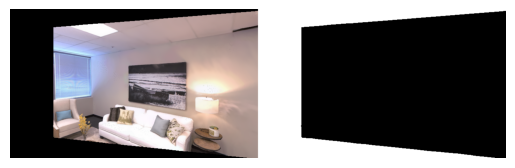

In [10]:
# Display the render image and mask image
if current_loop_index + 1 < len(flash3dreconstructor.w2c):
    rendered_img = Image.open(mask_render_path_diffusion)
    mask_img = Image.open(mask_path_diffusion)

    grid_img = make_image_grid([rendered_img, mask_img], rows=1, cols=2)
    plt.imshow(grid_img)
    plt.axis('off')
    plt.savefig(f'./imgs/before_inpainting_{current_loop_index}.jpg')

(384, 640, 3) (384, 640, 4)


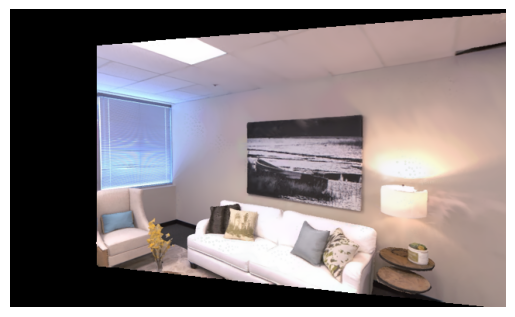

In [11]:
if current_loop_index + 1 < len(flash3dreconstructor.w2c):
    rendered_img = Image.open(mask_render_path_diffusion)
    mask_img = Image.open(mask_path_diffusion)
    rendered_img = np.array(rendered_img)
    mask_img = np.array(mask_img)
    print(mask_img.shape, rendered_img.shape)
    rendered_img = rendered_img[:, :, 0:3]
    rendered_img[rendered_img == 0] = 0
    # grid_img = make_image_grid([rendered_img, mask_img], rows=1, cols=2)
    plt.imshow(rendered_img)
    plt.axis('off')
    plt.savefig(f'./imgs/before_inpainting_{current_loop_index}.jpg')

In [ ]:
Prompt_diffusion = 'A indoor scene, a room, a window, two sofas.'

before resize (640, 384) (640, 384)
after resize (512, 512) (512, 512)


Loading pipeline components...:  33%|███▎      | 2/6 [00:02<00:04,  1.17s/it]c:\Users\UTastePC\miniconda3\envs\8536\lib\site-packages\transformers\tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Loading pipeline components...: 100%|██████████| 6/6 [00:07<00:00,  1.29s/it]


Prompt: A indoor scene, a room, a window, two sofas.


100%|██████████| 50/50 [00:03<00:00, 15.11it/s]


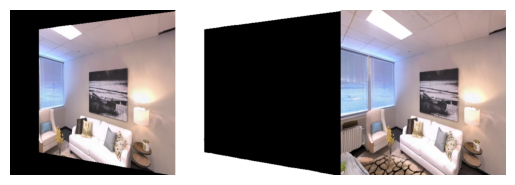

In [13]:
if current_loop_index + 1 < len(flash3dreconstructor.w2c):
    diffusion_img = generate_diffusion_img(original_input_img_path=intial_img_path,image_path=mask_render_path_diffusion, mask_path=mask_path_diffusion,
                                                    prompt_question=None,
                                                    prompt_diffusion=Prompt_diffusion,
                                                    base_model='stable-diffusion-v2', index=current_loop_index, strength=1.0,
                                                    negative_prompt="bad architecture, inconsistent, poor details, blurry") # 512*512

In [14]:
intial_img = Image.open(intial_img_path)
resized_diffusion_img = diffusion_img.resize((intial_img.size[0], intial_img.size[1]))

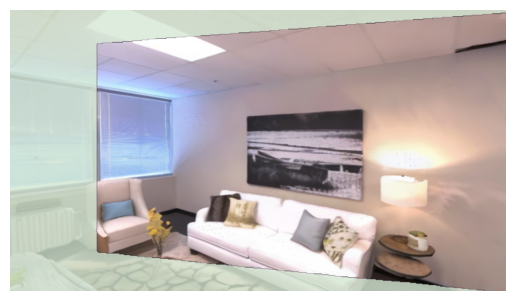

In [15]:
# Display the diffusion image
if current_loop_index + 1 < len(flash3dreconstructor.w2c):
    intial_img = Image.open(intial_img_path)
    mask_img = Image.open(mask_path_diffusion)
    mask_img = mask_img.resize((intial_img.size[0], intial_img.size[1]))
    mask_img = np.array(mask_img)
    
    resized_diffusion_img = diffusion_img.resize((intial_img.size[0], intial_img.size[1]))
    resized_diffusion_img = np.array(resized_diffusion_img)
    plt.imshow(resized_diffusion_img)

    mask_reduced = mask_img.copy().mean(axis=2)

    mask_img[mask_img == 0] = resized_diffusion_img[mask_img == 0]
    mask_img[mask_reduced==255] = [213,232,212]

    plt.imshow(mask_img, alpha=0.8)

    plt.axis('off')
    plt.savefig(f'./imgs/diffusion_{current_loop_index}.jpg')

In [16]:
flash3dreconstructor.model.to('cuda')

GaussianPredictor(
  (models): ModuleDict(
    (unidepth_extended): UniDepthExtended(
      (unidepth): UniDepthDepth(
        (depth_prediction_model): UniDepthV1(
          (pixel_encoder): DinoVisionTransformer(
            (patch_embed): PatchEmbed(
              (proj): Conv2d(3, 1024, kernel_size=(14, 14), stride=(14, 14))
              (norm): Identity()
            )
            (blocks): ModuleList(
              (0-23): 24 x NestedTensorBlock(
                (norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
                (attn): MemEffAttention(
                  (qkv): Linear(in_features=1024, out_features=3072, bias=True)
                  (attn_drop): Dropout(p=0.0, inplace=False)
                  (proj): Linear(in_features=1024, out_features=1024, bias=True)
                  (proj_drop): Dropout(p=0.0, inplace=False)
                )
                (ls1): LayerScale()
                (drop_path1): Identity()
                (norm2): LayerNorm((1024,),

In [17]:
# Postprocess the diffusion image
flash3dreconstructor.flash3d_post_process_diffusion_img(diffusion_img)

In [18]:
raise ValueError('Stop Here')

ValueError: Stop Here

In [30]:
flash3dreconstructor.flash3d_final_process()

Image saved as d:\Local\Courses\COMP8536\3dgs-utils\ANU-COMP8536-2024s2\flash3d/imgs/0_0_start_render.png
Image saved as d:\Local\Courses\COMP8536\3dgs-utils\ANU-COMP8536-2024s2\flash3d/imgs/0_1_start_render.png
Tracking Iteration 1, Loss: 114325.5312
Tracking Iteration 2, Loss: 105951.3828
Tracking Iteration 3, Loss: 95828.6562
Tracking Iteration 4, Loss: 84640.3438
Tracking Iteration 5, Loss: 73215.0234
Tracking Iteration 6, Loss: 62514.9297
Tracking Iteration 7, Loss: 53342.0703
Tracking Iteration 8, Loss: 45971.4805
Tracking Iteration 9, Loss: 40332.0469
Tracking Iteration 10, Loss: 36153.1328
Tracking Iteration 11, Loss: 33090.5703
Tracking Iteration 12, Loss: 30823.6250
Tracking Iteration 13, Loss: 29120.5000
Tracking Iteration 14, Loss: 27817.9668
Tracking Iteration 15, Loss: 26801.1523
Tracking Iteration 16, Loss: 25999.9453
Tracking Iteration 17, Loss: 25347.9434
Tracking Iteration 18, Loss: 24806.0527
Tracking Iteration 19, Loss: 24337.7031
Tracking Iteration 20, Loss: 23925.

In [31]:
flash3dreconstructor.flash3d_save_ply('demo-diffused')